In [ ]:
import os, os.path
import numpy as np
import pandas as pd
from model_attributes import *
from attribute_table import *
from model_afolu import AFOLU
from model_ippu import *
from model_circular_economy import *
from model_energy import *
from model_socioeconomic import *
from setup_analysis import *
from support_functions import *
import importlib
import time
import warnings
import matplotlib.pyplot as plt
import multiprocessing as mp
import pickle

"""
importlib.reload(ma)
importlib.reload(sa)
importlib.reload(sf)
importlib.reload(mafl)
importlib.reload(mc)
importlib.reload(mi)
importlib.reload(me)
importlib.reload(se)
"""

/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2479: UserWarning: Invalid subsector attribute 'key_varreqs_partial'. Valid return type values are:'pycategory_primary', 'abv_subsector', 'sector', 'abv_sector', 'key_varreqs_all'
  warnings.warn(f"Invalid subsector attribute '{return_type}'. Valid return type values are:{valid_rts}")
/Users/jsyme/Documents/Projects/git_jbus/lac_decarbonization/python/model_attributes.py:2261: FutureWarning: In a future version of pandas, a length 1 tuple will be returned when iterating over a groupby with a grouper equal to a list of length 1. Don't supply a list with a single grouper to avoid this warning.
  for desig, df in df_by_designation:


'\nimportlib.reload(ma)\nimportlib.reload(sa)\nimportlib.reload(sf)\nimportlib.reload(mafl)\nimportlib.reload(mc)\nimportlib.reload(mi)\nimportlib.reload(me)\nimportlib.reload(se)\n'

In [1]:
#df_input_data[[x for x in df_input_data.columns if ("pij_lndu" in x) and ("to_forests_primary" in x)]]

In [6]:


##  functions


###  NEED TO INTEGRATE THIS INTO MODEL AFOLU

def format_markov_matrix_as_field(
    mat: np.ndarray,
    key_vals: list,
    field_key: str = "key"
) -> pd.DataFrame:
    
    # setup as matrix
    df_mat = pd.DataFrame(mat, columns = key_vals)
    df_mat[field_key] = key_vals
    df_mat_melt = pd.melt(df_mat, id_vars = [field_key], value_vars = key_vals).sort_values(by = [field_key, "variable"])
    
    # get field names
    fields_names = model_attributes.build_varlist(
        model_afolu.subsec_name_lndu, 
        model_afolu.modvar_lndu_prob_transition, 
        restrict_to_category_values = key_vals
    )
    
    df_mat_melt["field"] = fields_names
    df_mat_melt.set_index("field", inplace = True)
    df_mat_melt = df_mat_melt[["value"]].transpose().reset_index(drop = True)
    # doing this only to drop index
    df_out = pd.DataFrame()
    df_out[df_mat_melt.columns] = df_mat_melt[df_mat_melt.columns]
    
    return df_out



def get_annual_transitions(fp_in: str, optimization_approach: str) -> pd.DataFrame:

    # get time periods
    attr_tp = model_attributes.dict_attributes["dim_time_period"]

    # clean up input
    df_annual_transition = pd.read_csv(fp_in)
    df_annual_transition = df_annual_transition[
        df_annual_transition["optimization_bound"].isin([optimization_approach])
    ]
    # filter time periods
    dict_year_to_tp = attr_tp.field_maps.get(f"year_to_{model_attributes.dim_time_period}")
    df_annual_transition[model_attributes.dim_time_period] = df_annual_transition["year"].replace(dict_year_to_tp)
    df_annual_transition = df_annual_transition[
        df_annual_transition[model_attributes.dim_time_period].isin(attr_tp.key_values)
    ].drop(["year"], axis = 1).sort_values(by = ["country", "time_period"]).reset_index(drop = True)

    # rename
    fields_rnm = [x for x in df_annual_transition.columns if (x not in ["country", "optimization_bound", "time_period"])]
    dict_rnm = dict([(x, f"pij_lndu_{x}") for x in fields_rnm])
    df_annual_transition.rename(columns = dict_rnm, inplace = True)
    
    return df_annual_transition





# set up some required components
optimization_approach = "max_diagonal"
dir_read = "/Users/jsyme/Downloads"

# load latest data/Users/jsyme/Downloads/data_complete_future_2022_08_24_test1.csv
df_base_inputs =  pd.read_csv(os.path.join(dir_ref, "fake_data", "fake_data_complete.csv"))
#df_input_data = pd.read_csv("/Users/jsyme/Downloads/data_complete_future_2022_07_31_test.csv")
df_input_data = pd.read_csv(os.path.join(dir_read, "data_complete_future_2022_08_24_test1.csv")).rename(columns = {"Nation": "country"})
all_vars = list(model_attributes.dict_variables_to_model_variables.keys())
df_input_data = df_input_data[["time_period", "country"] + [x for x in df_input_data.columns if x in all_vars]]
all_countries = sorted(list(set(df_input_data["country"])))
#
df_mean_transition_0 = pd.read_csv(fp_csv_transition_probability_estimation_mean)#fp_csv_transition_probability_estimation_mean)
dict_rename = dict([(x, f"pij_lndu_{x}") for x in df_mean_transition_0.columns if (x not in ["country", "year", "optimization_bound"])])
df_mean_transition_0.rename(columns = dict_rename, inplace = True)
df_annual_transitions = get_annual_transitions(fp_csv_transition_probability_estimation_annual, optimization_approach)


# setup data frame dictionary
dict_df_input = {}
dict_df_mts = {}
dict_df_transition = {}
fields_pij_to_replace_in_input = [x for x in df_mean_transition_0.columns if (x not in ["country", "year", "optimization_bound"])]
    
for country in all_countries:
    
    # update input data data frames
    df_input = df_input_data[df_input_data["country"] == country].reset_index(drop = True).copy();
    dict_df_input.update({country: df_input})
    
    # update mean transition data frames
    df_mts = df_mean_transition_0[
        df_mean_transition_0["country"].isin([country]) & 
        df_mean_transition_0["optimization_bound"].isin([optimization_approach])
    ].copy().reset_index(drop = True)
    dict_df_mts.update({country: df_mts})
    
    # build transitions
    df_transition = df_input[["time_period"]].copy()
    df_mts.drop(["country", "optimization_bound"], axis = 1, inplace = True)
    df_mts["mrg_tmp"] = 0
    df_transition["mrg_tmp"] = 0
    
    df_transition = pd.merge(df_transition, df_mts, on = ["mrg_tmp"]).drop(["mrg_tmp"], axis = 1)
    df_annual_transitions_cur = df_annual_transitions[
        df_annual_transitions["country"].isin([country]) & 
        df_annual_transitions["optimization_bound"].isin([optimization_approach])
    ].drop(["country", "optimization_bound"], axis = 1)
    
    
    df_transition = pd.concat(
        [
            df_transition[~df_transition["time_period"].isin(list(df_annual_transitions_cur["time_period"]))],
            df_annual_transitions_cur
        ],
        axis = 0
    ).sort_values(by = ["time_period"]).reset_index(drop = True)
    
    dict_df_transition.update({country: df_transition})



    
# initialize the model
model_afolu = AFOLU(model_attributes)




In [18]:

# initialize some relevant info
crop_area_total = 0.0
t_0 = time.time()
attr_lndu = model_attributes.get_attribute_table(model_attributes.subsec_name_lndu)

# get some indices
dict_kv_inds = dict(zip(attr_lndu.key_values, [attr_lndu.get_key_value_index(x) for x in attr_lndu.key_values]))
# update parameters governing change in transition probabilities
time_period_stable = None # set to none to default to the last time step

"""
#MIN DIAG

scalar_into_cropland = 0.915
scalar_into_forest = 1
dict_inds_input = {
    (dict_kv_inds["forests_primary"], dict_kv_inds["wetlands"]): 1,
    (dict_kv_inds["forests_primary"], dict_kv_inds["settlements"]): 1,
    (dict_kv_inds["forests_primary"], dict_kv_inds["grasslands"]): 4.05,#3.75,#5.5,
    (dict_kv_inds["forests_primary"], dict_kv_inds["other"]): 0.9,#0.98
    (dict_kv_inds["forests_secondary"], dict_kv_inds["grasslands"]): 1.5,
    (dict_kv_inds["forests_secondary"], dict_kv_inds["other"]): 0.96,
    (dict_kv_inds["grasslands"], dict_kv_inds["croplands"]): 1.8,
    (dict_kv_inds["croplands"], dict_kv_inds["grasslands"]): 1.4,
    (dict_kv_inds["grasslands"], dict_kv_inds["grasslands"]): 1.2,
    # NEW
    (dict_kv_inds["grasslands"], dict_kv_inds["other"]): 0.9,
    (dict_kv_inds["croplands"], dict_kv_inds["other"]): 1
}
"""



#MAX DIAG

scalar_into_cropland = 0.981
scalar_into_forest = 1
dict_inds_input = {
    (dict_kv_inds["forests_primary"], dict_kv_inds["wetlands"]): 1,
    (dict_kv_inds["forests_primary"], dict_kv_inds["settlements"]): 1,
    (dict_kv_inds["forests_primary"], dict_kv_inds["grasslands"]): 3.3,#3.75,#5.5,
    (dict_kv_inds["forests_primary"], dict_kv_inds["other"]): 0.9,#0.98
    (dict_kv_inds["forests_secondary"], dict_kv_inds["grasslands"]): 1.5,
    (dict_kv_inds["forests_secondary"], dict_kv_inds["other"]): 0.96,
    (dict_kv_inds["grasslands"], dict_kv_inds["croplands"]): 1,
    (dict_kv_inds["croplands"], dict_kv_inds["grasslands"]): 1.5,
    (dict_kv_inds["grasslands"], dict_kv_inds["grasslands"]): 1.2,
    # NEW
    (dict_kv_inds["grasslands"], dict_kv_inds["other"]): 0.9,
    (dict_kv_inds["croplands"], dict_kv_inds["other"]): 1
}

#dict_inds_input = {}
# save off so we have latest assumptions
dict_transition_prob_transformation_assumptions = {
    "attr_lndu": attr_lndu,
    "dict_inds_input": dict_inds_input,
    "scalar_into_cropland": scalar_into_cropland,
    "scalar_into_forest": scalar_into_forest,
    "time_period_stable": time_period_stable
}


#scalar_into_forest_secondary = 0.98
#scalar_into_pstr = 3
#scalar_into_other = 0.98
global ind_pstr
ind_crop = attr_lndu.get_key_value_index(model_afolu.cat_lndu_crop)
ind_frst_primary = attr_lndu.get_key_value_index("forests_primary")
ind_frst_secondary = attr_lndu.get_key_value_index("forests_secondary")
ind_other = attr_lndu.get_key_value_index("other")
ind_pstr = attr_lndu.get_key_value_index(model_afolu.cat_lndu_grass)

# turn off warnings
warnings.filterwarnings("ignore")

# setup the callback function
global countries_ord
global vec_crop_area_total
global vec_pstr_area_total
countries_ord = []
vec_crop_area_total = []
vec_pstr_area_total = []

def get_result(result_tuple):
    
    global countries_ord
    global vec_crop_area_total
    global vec_pstr_area_total
    
    result, country = result_tuple
    
    vec_sum_crop = np.sum(
        model_attributes.get_standard_variables(
            result, 
            model_afolu.modvar_agrc_area_crop, 
            return_type = "array_base"
        ), 
        axis = 1
    )
    
    vec_sum_pstr = model_attributes.get_standard_variables(
        result, 
        model_afolu.modvar_lndu_area_by_cat, 
        return_type = "array_base"
    )[:, ind_pstr]

    countries_ord.append(country)
    vec_crop_area_total.append(vec_sum_crop)
    vec_pstr_area_total.append(vec_sum_pstr)
    
    
## function to perform scaling
def scale_transitions(
    transition_scalar_crop: float,
    transition_scalar_frst_primary: float,
    df_input0: pd.DataFrame,
    df_mean_transition: pd.DataFrame,
    ind_crop: int,
    ind_frst_primary: int,
    dict_scalars: dict,
    model_afolu: AFOLU = model_afolu,
    model_attributes: ModelAttributes = model_attributes,
    time_period_begin_shift: int = None,
    time_period_stable: int = None,
    **kwargs # sent to pd.DataFrame.interpolate()
) -> pd.DataFrame:
    
    # get the time period where transition probabilities become stable
    time_period_stable = int(max(df_input0[model_attributes.dim_time_period])) if (time_period_stable is None) else time_period_stable
    time_period_stable = max(min(df_input0[model_attributes.dim_time_period]), time_period_stable)
    time_period_stable = min(max(df_input0[model_attributes.dim_time_period]), time_period_stable)
    time_period_begin_shift = 3 if (time_period_begin_shift is None) else time_period_begin_shift
    
    # get arrays
    df_input = df_input0.copy().drop(fields_pij_to_replace_in_input, axis = 1)
    df_input = pd.merge(df_input, df_mean_transition, on = ["time_period"]).sort_values(by = ["time_period"]).reset_index(drop = True)
    arrs_transition = model_afolu.get_markov_matrices(df_input, len(df_input))[0]
    mat_q = arrs_transition[time_period_begin_shift]
    # setup nodes to increase (cropland remaining)
    trans_c_to_c = mat_q[ind_crop, ind_crop]

    # don't allow cropland into cropland to exceed 1
    if (trans_c_to_c*transition_scalar_crop > 1):
        inds = [x for x in range(len(mat_q)) if (x != ind_crop)]
        dict_inds = dict(zip([(x, ind_crop) for x in inds], [transition_scalar_crop for x in inds]))
        # set scalar for crop to crop
        scalar_crop_to_crop = (1 + trans_c_to_c)/(2*trans_c_to_c)
        dict_inds.update({(ind_crop, ind_crop): scalar_crop_to_crop})
    else:
        dict_inds = {(ind_crop, ): transition_scalar_crop}
    
    # update forest, other, pastures
    dict_inds.update({
        (ind_frst_primary, ): transition_scalar_frst_primary
    })
    dict_inds.update(dict_scalars)

    mat_q_final = model_afolu.adjust_transition_matrix(mat_q, dict_inds)

    # build dataframe
    
    df_q = df_mean_transition.copy()
    df_q = df_q[df_q[model_attributes.dim_time_period] < time_period_begin_shift]
    #df_q_final = format_markov_matrix_as_field(mat_q_final, attr_lndu.key_values)
    df_q_final = model_afolu.format_transition_matrix_as_input_dataframe(mat_q_final)
    df_q_final[model_attributes.dim_time_period] = time_period_stable
    df_q = pd.concat([df_q[df_q_final.columns], df_q_final], axis = 0).reset_index(drop = True)
    df_q = pd.merge(df_input[[model_attributes.dim_time_period]], df_q, how = "left")
    df_q.interpolate(inplace = True, **kwargs)

    for k in df_q.columns:
        df_input[k] = np.array(df_q[k])
    
    return df_input, df_q


# setup output transitions
df_q_out = []
dict_inputs = {}

if __name__ == "__main__":
    
    pool = mp.Pool()

    iterator = all_countries#["dominican_republic"]#["costa_rica"]:
        
    for country in enumerate(iterator):
        
        ind, country = country
        
        # filter and prepare
        df_input = dict_df_input[country];
        df_cat = df_base_inputs[[x for x in df_base_inputs.columns if x not in df_input.columns]]
        df_input = pd.concat([df_input, df_cat], axis = 1)

        # update some fields
        df_input["frac_agrc_initial_yield_feed_sugar_cane"] = 0
        df_input["lndu_reallocation_factor"] = 0
        df_input["elasticity_agrc_sugar_cane_demand_to_income"] = 0.05
        
        # test
        if False:#country == "argentina":
            scalar_into_cropland = 1#.4
            scalar_into_forest = 1#0.4
            dict_inds_input_pass = {}
        else:
            dict_inds_input_pass = dict_inds_input
            
        ##  update transitions with scalar
        df_input, df_q = scale_transitions(
            scalar_into_cropland,
            scalar_into_forest,
            df_input,
            dict_df_transition[country],
            ind_crop,
            ind_frst_primary, 
            dict_inds_input_pass,
            time_period_stable = time_period_stable
            # TEMP TESTING
            #method = "spline", 
            #order = 3
        )
        
        dict_inputs.update({country: df_input})
        
        
        # add country field back into output and add to data frame
        df_q["country"] = country
        if len(df_q_out) == 0:
            df_q_out = [df_q for x in iterator]
        else:
            df_q_out[ind] = df_q[df_q_out[0].columns]
    
        pool.apply_async(
            model_afolu.project,
            args = (df_input, country),
            callback = get_result
        )
        
    pool.close()
    pool.join()

    
# some aggregations after collecting output
df_q_out = pd.concat(df_q_out, axis = 0).sort_values(by = ["country", model_attributes.dim_time_period]).reset_index(drop = True)

vec_crop_trajectory = np.sum(np.array(vec_crop_area_total), axis = 0)
vec_pstr_trajectory = np.sum(np.array(vec_pstr_area_total), axis = 0)

# some notifications
t_elapse = np.round(time.time() - t_0, 2)
print(f"Runs complete.\n\tTotal time: {t_elapse} seconds\n")


# check crops
dif = np.round(vec_crop_trajectory[-1]/vec_crop_trajectory[0], 3)
print(f"With scalar at {scalar_into_cropland}:\t{dif}")

# check grassland
dif = np.round(vec_pstr_trajectory[-1]/vec_pstr_trajectory[0], 3)
print(f"Change in grassland:\t{dif}")

if True:
    # write output
    df_q_out.to_csv(
        fpt_csv_transition_probability_estimation_mean_with_growth%(optimization_approach),
        index = None,
        encoding = "UTF-8"
    )
    # write assumptions to accompanying file
    fp_pkl = fpt_pkl_transition_probability_estimation_mean_with_growth_assumptions%(optimization_approach)
    with open(fp_pkl, "wb") as fp:
        pickle.dump(dict_transition_prob_transformation_assumptions, fp, protocol=pickle.HIGHEST_PROTOCOL)

Runs complete.
	Total time: 6.03 seconds

With scalar at 0.981:	1.21
Change in grassland:	1.109


In [6]:
df_q_out = pd.read_csv(
    fpt_csv_transition_probability_estimation_mean_with_growth%("max_diagonal"),
)

<AxesSubplot:>

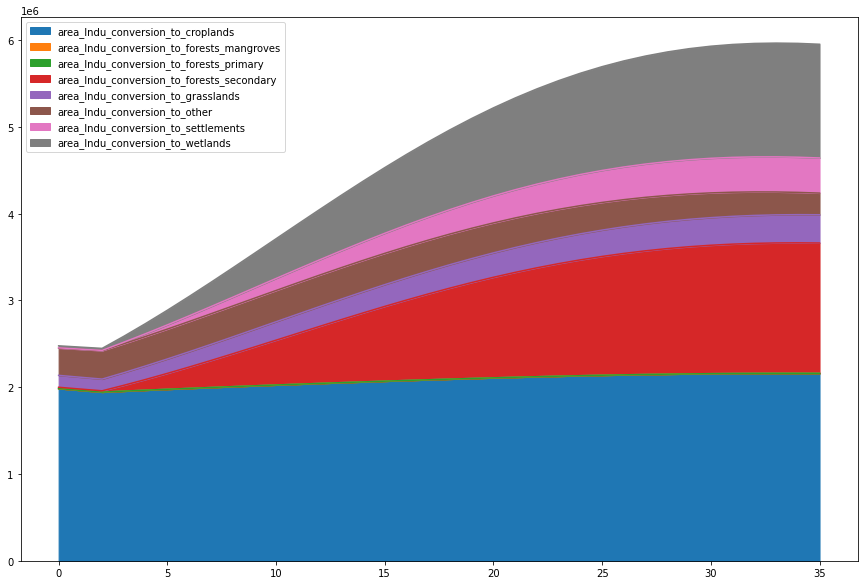

In [188]:
df_output = model_afolu.project(df_input2)
fig, ax = plt.subplots(figsize = (15, 10))
df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion_to" in x)]].plot.area(ax = ax)



In [202]:
df_input2[[x for x in df_input2.columns if "carrying_capacity" in x]];

In [200]:
np.round(model_afolu2.mat_trans_unadj[0], 3)

array([[0.995, 0.   , 0.   , 0.   , 0.   , 0.005, 0.   , 0.   ],
       [0.   , 0.998, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.006, 0.   , 0.99 , 0.   , 0.004, 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.998, 0.   , 0.   , 0.   , 0.   ],
       [0.012, 0.   , 0.   , 0.   , 0.986, 0.001, 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.   , 0.   , 0.997, 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.001, 0.   , 0.   , 0.998, 0.   ],
       [0.01 , 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.99 ]])

In [262]:
np.round(model_afolu2.mat_trans_adj[30], 3)

array([[0.958, 0.   , 0.   , 0.   , 0.042, 0.   , 0.   , 0.   ],
       [0.   , 0.998, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.006, 0.   , 0.   , 0.   , 0.994, 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.942, 0.056, 0.   , 0.   , 0.   ],
       [0.021, 0.   , 0.   , 0.   , 0.979, 0.   , 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.   , 0.   , 0.997, 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.001, 0.   , 0.   , 0.998, 0.   ],
       [0.009, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.991]])

<AxesSubplot:>

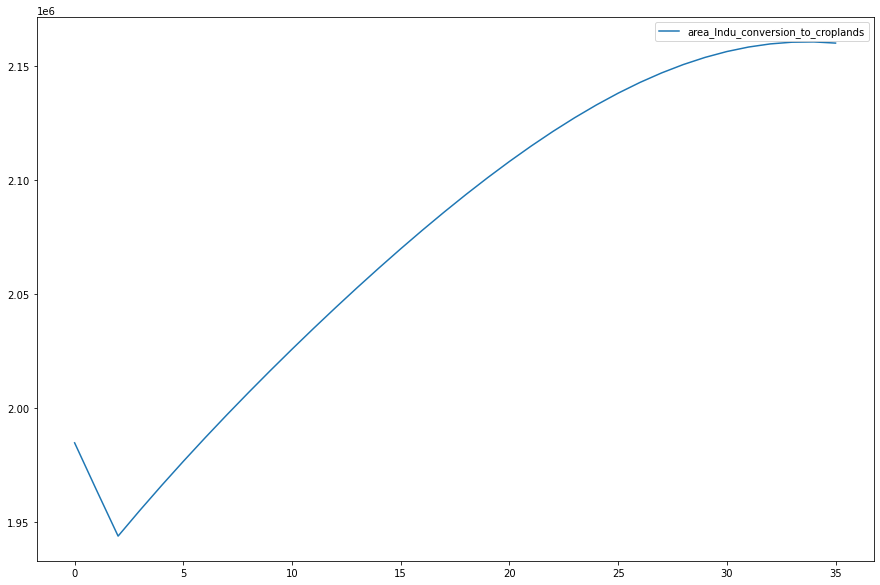

In [340]:
#import model_afolu as mafl
#importlib.reload(mafl)
#model_afolu2 = mafl.AFOLU(model_attributes)

df_input2 = dict_inputs["argentina"].copy()
luf = 0
df_input2["lndu_reallocation_factor"] = luf
df_input2["frac_gnrl_eating_red_meat"] = [0.95, 0.95, 0.95] + [max(0.95 - x*0.01, 0.3) for x in range(33)]
df_input2["scalar_lvst_carrying_capacity"] = [1 + x*0.01 for x in range(36)]
#df_input2[["gdp_mmm_usd"]] = [530, 532, 533, 538, 542] + list(df_input2["gdp_mmm_usd"])[5:]
#df_input2["gdp_mmm_usd"].iloc[0] = 700
#df_input2[["gdp_mmm_usd"]].plot()
#


df_output = model_afolu2.project(df_input2)
fig, ax = plt.subplots(figsize = (15, 10))
#ax.set_xlim(10, 36)
#ax.set_ylim(0, 900)
#ax.set_ylim(0, 10)
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot.area(ax = ax)
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x) and ("forests_primary" in x)]].plot.area(ax = ax)
#plt.plot(model_afolu2.vec_soil_soc_total_mineral)
#df_output[[x for x in df_output.columns if ("emission_co2e_subsector" in x)]].plot(ax = ax)#.area(ax = ax)
#df_output[[x for x in df_output.columns if ("emission_co2e_co2" in x)]]
df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" in x) and ("to_cropland" in x)]].plot(ax = ax)
#df_output[["area_lndu_conversion_from_forests_primary"]].astype(int)


In [341]:
df_output[[x for x in df_output.columns if ("net_import" in x) and ("lvst" in x)]]

,net_imports_change_lvst_buffalo,net_imports_change_lvst_cattle_dairy,net_imports_change_lvst_cattle_nondairy,net_imports_change_lvst_chickens,net_imports_change_lvst_goats,net_imports_change_lvst_horses,net_imports_change_lvst_mules,net_imports_change_lvst_pigs,net_imports_change_lvst_sheep
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,-2608218.0,-5199265.0,102683.0,-457716.0,-251020.0,-6073.0,4630720.0,-1457841.0
2,0.0,-2459342.0,-7502899.0,93703.0,-669403.0,-367113.0,-8882.0,4402036.0,-2132068.0
3,0.0,-2303881.0,-9669916.0,85515.0,-867869.0,-475954.0,-11514.0,4185663.0,-2764188.0
4,0.0,-2682426.0,-12148153.0,77226.0,-1090316.0,-597949.0,-14466.0,3938961.0,-3472688.0
5,0.0,-3045205.0,-14452050.0,69735.0,-1296358.0,-710946.0,-17200.0,3707225.0,-4128940.0
6,0.0,-3014004.0,-14007546.0,70699.0,-1256452.0,-689060.0,-16670.0,3730486.0,-4001839.0
7,0.0,-2979589.0,-13567605.0,71631.0,-1216908.0,-667374.0,-16145.0,3752081.0,-3875890.0
8,0.0,-2942137.0,-13132519.0,72530.0,-1177755.0,-645901.0,-15626.0,3772006.0,-3751184.0
9,0.0,-2901833.0,-12702570.0,73396.0,-1139019.0,-624658.0,-15112.0,3790258.0,-3627806.0


In [320]:
np.round(model_afolu2.mat_trans_unadj[34],3)

array([[0.913, 0.   , 0.   , 0.038, 0.   , 0.005, 0.01 , 0.033],
       [0.   , 0.998, 0.   , 0.   , 0.   , 0.   , 0.   , 0.001],
       [0.006, 0.   , 0.98 , 0.   , 0.015, 0.   , 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.999, 0.   , 0.   , 0.   , 0.   ],
       [0.022, 0.   , 0.   , 0.   , 0.977, 0.001, 0.   , 0.   ],
       [0.003, 0.   , 0.   , 0.   , 0.   , 0.997, 0.   , 0.   ],
       [0.001, 0.   , 0.   , 0.001, 0.   , 0.   , 0.998, 0.   ],
       [0.009, 0.   , 0.   , 0.   , 0.   , 0.   , 0.   , 0.991]])

In [28]:
#df_output[[x for x in df_output.columns if "net_imports" in x]]

In [407]:
ab = np.ones(5)
np.put(ab, np.array([1, 4]), np.array([0.4, 0.9]))
ab

array([1. , 0.4, 1. , 1. , 0.9])

In [432]:
print(np.round(model_afolu.mat_trans_unadj[0], 3))
print("\n")
print(np.round(model_afolu.mat_trans_unadj[15], 3))

[[0.95  0.    0.    0.    0.045 0.005 0.    0.   ]
 [0.    0.97  0.    0.    0.    0.03  0.    0.   ]
 [0.001 0.    0.996 0.    0.003 0.    0.    0.   ]
 [0.032 0.    0.    0.95  0.001 0.    0.006 0.01 ]
 [0.016 0.    0.    0.002 0.975 0.005 0.    0.001]
 [0.    0.    0.    0.    0.005 0.995 0.    0.   ]
 [0.    0.    0.    0.    0.01  0.    0.99  0.   ]
 [0.    0.    0.    0.019 0.    0.    0.    0.98 ]]


[[0.918 0.025 0.    0.    0.05  0.005 0.    0.   ]
 [0.    0.97  0.    0.    0.    0.03  0.    0.   ]
 [0.001 0.    0.992 0.    0.008 0.    0.    0.   ]
 [0.036 0.    0.    0.951 0.001 0.    0.002 0.009]
 [0.017 0.    0.    0.004 0.973 0.005 0.    0.001]
 [0.004 0.    0.    0.    0.002 0.994 0.    0.   ]
 [0.007 0.    0.    0.    0.003 0.    0.99  0.   ]
 [0.002 0.007 0.    0.003 0.    0.    0.008 0.98 ]]


In [461]:
print(np.round(model_afolu2.mat_trans_adj[0], 3))
print("\n")
print(np.round(model_afolu2.mat_trans_adj[30], 3))

[[0.95  0.    0.    0.    0.045 0.005 0.    0.   ]
 [0.    0.97  0.    0.    0.    0.03  0.    0.   ]
 [0.001 0.    0.999 0.    0.    0.    0.    0.   ]
 [0.032 0.    0.    0.95  0.001 0.    0.006 0.01 ]
 [0.016 0.001 0.    0.003 0.974 0.005 0.    0.001]
 [0.    0.    0.    0.    0.005 0.995 0.    0.   ]
 [0.    0.    0.    0.    0.01  0.    0.99  0.   ]
 [0.    0.    0.    0.019 0.    0.    0.    0.98 ]]


[[0.943 0.    0.    0.    0.052 0.005 0.    0.   ]
 [0.    0.97  0.    0.    0.    0.03  0.    0.   ]
 [0.001 0.    0.999 0.    0.    0.    0.    0.   ]
 [0.037 0.    0.    0.949 0.001 0.    0.005 0.007]
 [0.027 0.003 0.    0.092 0.874 0.004 0.    0.   ]
 [0.002 0.    0.    0.    0.004 0.994 0.    0.   ]
 [0.004 0.    0.    0.    0.006 0.    0.99  0.   ]
 [0.004 0.002 0.    0.006 0.    0.    0.006 0.98 ]]


<AxesSubplot:>

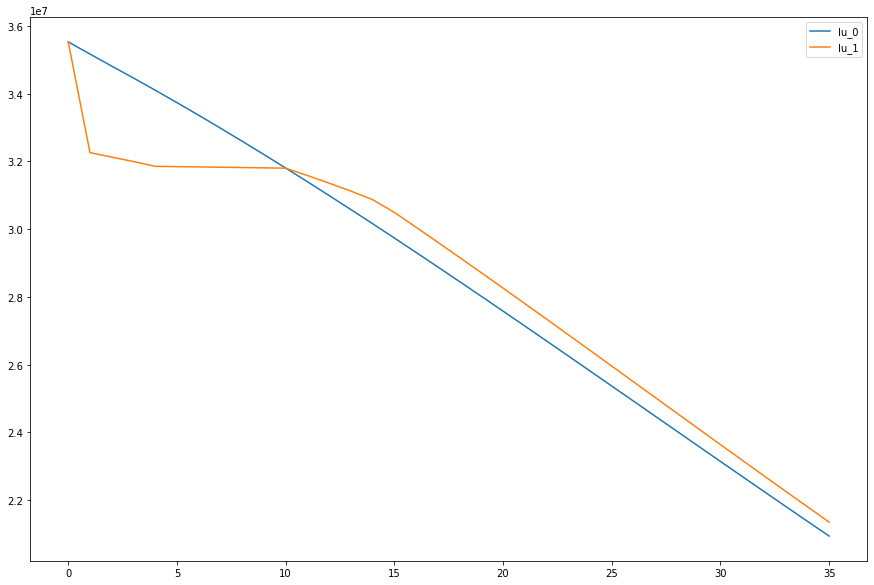

In [215]:
 
field = "area_lndu_forests_primary"
df_plot = pd.DataFrame({})


for luf in [0, 1]:

    df_input2["lndu_reallocation_factor"] = luf

    df_project_afolu = model_afolu.project(df_input2)
    #df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

    df_plot[f"lu_{luf}"] = np.array(df_project_afolu[field])
    #print("--"*30 + "\n\n")
    
fig, ax = plt.subplots(figsize = (15, 10))
#ax.set_xlim()
df_plot.plot(ax = ax)

    type_0        type_1
31     0.0  1.768262e+07
32     0.0  1.672176e+07
33     0.0  1.574300e+07
34     0.0  1.474730e+07
35     0.0  1.373556e+07


<AxesSubplot:>

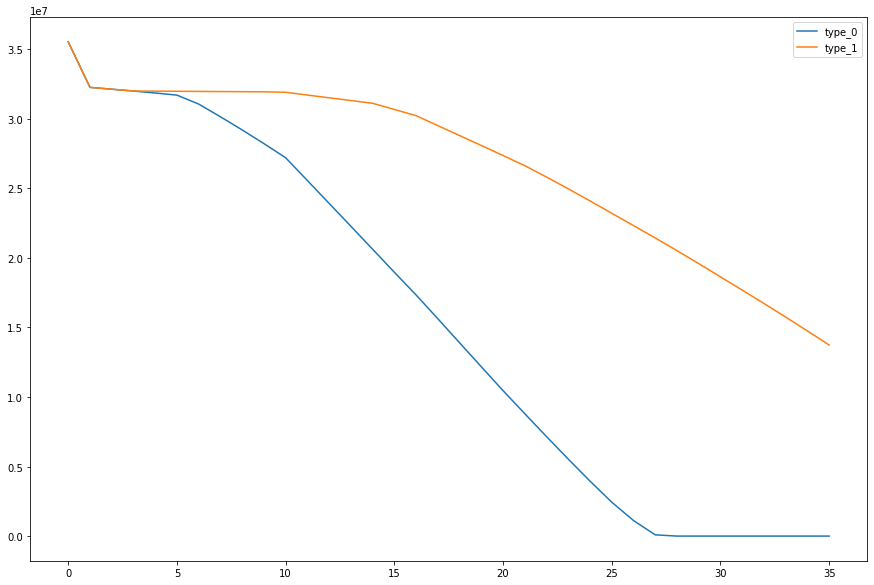

In [216]:
#importlib.reload(mafl)
#model_afolu2 = mafl.AFOLU(model_attributes)
field = "area_lndu_forests_primary"
df_plot = pd.DataFrame({})

dict_fem = {
    0: 0.95,
    1: [0.95, 0.95, 0.95] + [max(0.95 - x*0.06, 0.3) for x in range(33)]
}
df_input2["lndu_reallocation_factor"] = luf

for luf in [0, 1]:
    df_input2["lndu_reallocation_factor"] = 1
    df_input2["frac_gnrl_eating_red_meat"] = dict_fem[luf]
    df_project_afolu = model_afolu.project(df_input2)
    #df_cs_integrated = sf.merge_output_df_list([df_cs_integrated, df_project_afolu], sa.model_attributes, "concatenate")

    df_plot[f"type_{luf}"] = df_project_afolu[field]
    #print("--"*30 + "\n\n")

print(df_plot.tail())

fig, ax = plt.subplots(figsize = (15, 10))
#ax.set_xlim()
df_plot.plot(ax = ax)

In [365]:
mat = model_afolu2.mat_trans_unadj[10]
mat2 = model_afolu2.adjust_transition_matrix(mat, 
    {(4,): 0.907420723579188, (0,): 0.9645141241371074, (5,): 1, (7,): 1, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}
)

print(np.round(mat, 3))
print("\n")
print(np.round(mat2, 3))

[[0.985 0.    0.    0.001 0.012 0.001 0.    0.001]
 [0.034 0.96  0.    0.    0.006 0.    0.    0.   ]
 [0.001 0.    0.993 0.    0.004 0.    0.    0.001]
 [0.025 0.    0.013 0.962 0.    0.    0.    0.   ]
 [0.012 0.001 0.    0.002 0.984 0.    0.    0.001]
 [0.005 0.    0.    0.001 0.    0.994 0.    0.   ]
 [0.008 0.    0.    0.001 0.    0.    0.99  0.001]
 [0.038 0.    0.    0.002 0.    0.    0.    0.96 ]]


[[0.95  0.002 0.    0.031 0.011 0.001 0.004 0.001]
 [0.032 0.962 0.    0.    0.006 0.    0.    0.   ]
 [0.001 0.    0.994 0.    0.004 0.    0.    0.001]
 [0.024 0.    0.013 0.963 0.    0.    0.    0.   ]
 [0.012 0.024 0.    0.067 0.893 0.    0.003 0.001]
 [0.005 0.    0.    0.001 0.    0.994 0.    0.   ]
 [0.008 0.    0.    0.001 0.    0.    0.99  0.001]
 [0.036 0.    0.    0.003 0.    0.    0.    0.96 ]]


In [ ]:
### da1 = {(4,): 0.9969707311914674, (0,): 0.9842874834995257, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}
da2 = {(4,): 0.9957375277938012, (0,): 0.9804952981471459, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}
da3 = {(4,): 0.9957979820749324, (0,): 0.9801357186808458, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}
da4 = {(4,): 0.9748895657084969, (0,): 0.981223631838834, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}

m1 = model_afolu2.adjust_transition_matrix(model_afolu2.mat_trans_unadj[0], da1)
m2 = model_afolu2.adjust_transition_matrix(model_afolu2.mat_trans_unadj[1], da2)
m3 = model_afolu2.adjust_transition_matrix(model_afolu2.mat_trans_unadj[2], da3)
m4 = model_afolu2.adjust_transition_matrix(model_afolu2.mat_trans_unadj[3], da4)
            
np.round(m3, 3)


In [204]:
[1 if (x == 3) else 0 for x in range(5)]


[0, 0, 0, 1, 0]

In [203]:
(1 - 0.963228895316777)/0.0112

3.2831343467163374

In [279]:
model_afolu2.mat_trans_adj[14][:, 1]

array([0.00000000e+00, 9.75263451e-01, 0.00000000e+00, 0.00000000e+00,
       0.00000000e+00, 1.29221506e-04, 3.89578027e-04, 3.89902390e-04])

<AxesSubplot:>

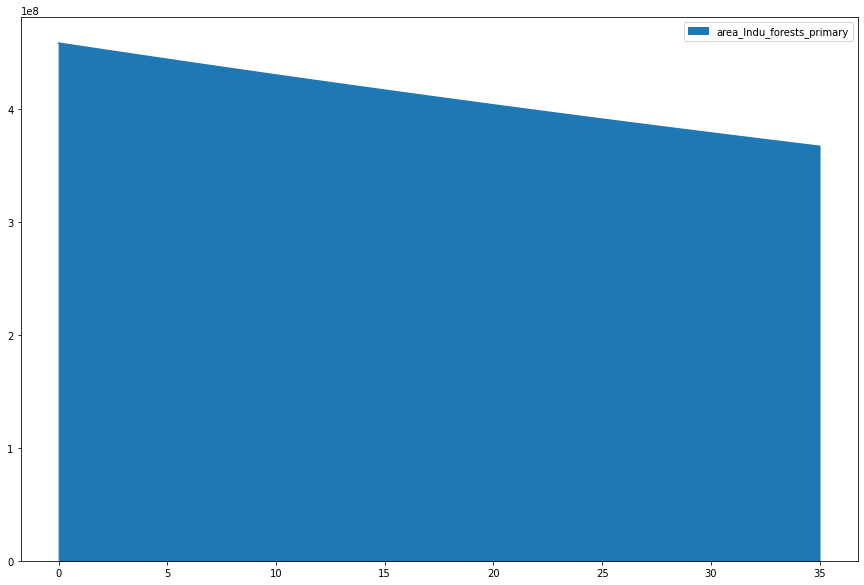

In [283]:
df_input["lndu_reallocation_factor"] = 0
df_output = model_afolu.project(df_input)
fig, ax = plt.subplots(figsize = (15, 10))
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot.area(ax = ax)
df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x) and ("forests_primary" in x)]].plot.area(ax = ax)

In [134]:
#model_afolu.mat_trans_adj[:,:, 5]
df_input2[[x for x in df_input2.columns if "_to_other" in x]].tail()

,ef_lndu_conv_croplands_to_other_gg_co2_ha,ef_lndu_conv_forests_mangroves_to_other_gg_co2_ha,ef_lndu_conv_forests_primary_to_other_gg_co2_ha,ef_lndu_conv_forests_secondary_to_other_gg_co2_ha,ef_lndu_conv_grasslands_to_other_gg_co2_ha,ef_lndu_conv_other_to_other_gg_co2_ha,ef_lndu_conv_settlements_to_other_gg_co2_ha,ef_lndu_conv_wetlands_to_other_gg_co2_ha,pij_lndu_croplands_to_other,pij_lndu_forests_mangroves_to_other,pij_lndu_forests_primary_to_other,pij_lndu_forests_secondary_to_other,pij_lndu_grasslands_to_other,pij_lndu_other_to_other,pij_lndu_settlements_to_other,pij_lndu_wetlands_to_other
31,0,0.000575,0.000081,0.000023,0,0,0,0,0.005727,0.001,0.000137,0.000965,0.006502,0.999,0.00068,0.000684
32,0,0.000575,0.000081,0.000023,0,0,0,0,0.005727,0.001,0.000136,0.000963,0.006479,0.999,0.00068,0.000684
33,0,0.000575,0.000081,0.000023,0,0,0,0,0.005727,0.001,0.000136,0.000962,0.006457,0.999,0.00068,0.000684
34,0,0.000575,0.000081,0.000023,0,0,0,0,0.005727,0.001,0.000135,0.000961,0.006434,0.999,0.00068,0.000684
35,0,0.000575,0.000081,0.000023,0,0,0,0,0.005727,0.001,0.000135,0.000960,0.006412,0.999,0.00068,0.000684


dict_adj: {(4,): 1.0, (0,): 1.0, (5,): 1, (7,): 1, (2, 1): 1, (2, 3): 1, (2, 5): 1, (2, 6): 1, (2, 7): 1}




<AxesSubplot:>

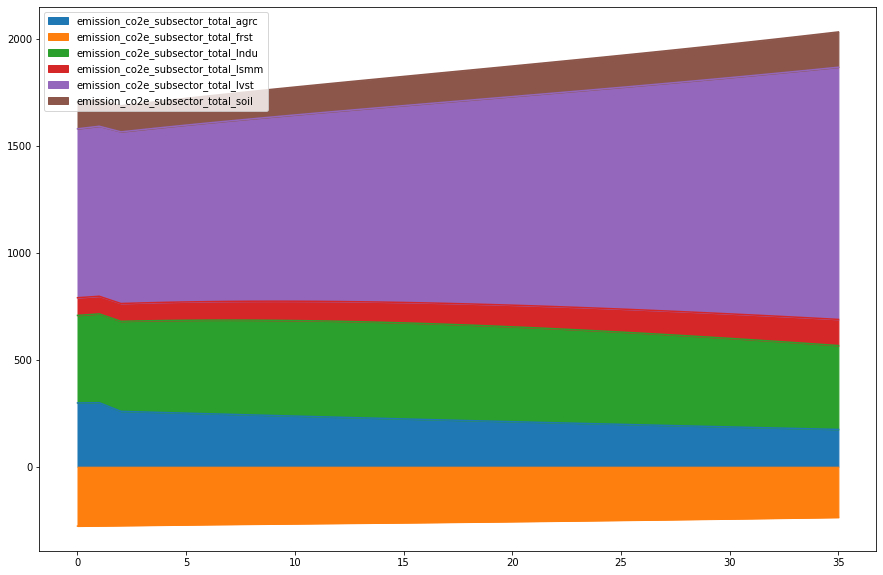

In [4]:
df_output = model_afolu.project(df_input)
fig, ax = plt.subplots(figsize = (15, 10))
#df_output[[x for x in df_output.columns if ("frac_area" in x) and ("calculated" in x)]].plot.area(ax = ax)
#df_output[[x for x in df_output.columns if ("area_lndu" in x) and ("conversion" not in x)]].plot.area(ax = ax)
df_output[[x for x in df_output.columns if ("emission_co2e" in x) and ("subsector" in x)]].plot.area(ax = ax)

In [49]:
[x for x in df_input.columns if "carrying" in x]

['scalar_lvst_carrying_capacity']

In [66]:
#dict_kv_inds = dict(zip(attr_lndu.key_values, [attr_lndu.get_key_value_index(x) for x in attr_lndu.key_values]))


#df_out = model_afolu.project(df_input)
#df_out[[x for x in df_out.columns if ("area_lndu" in x) and ("conversion" not in x)]]

In [23]:
df_input[[x for x in df_input.columns if ("pij" in x) and ("to_other" in x)]]

,pij_lndu_croplands_to_other,pij_lndu_forests_mangroves_to_other,pij_lndu_forests_primary_to_other,pij_lndu_forests_secondary_to_other,pij_lndu_grasslands_to_other,pij_lndu_other_to_other,pij_lndu_settlements_to_other,pij_lndu_wetlands_to_other
0,0.000192,0.0,0.003995,0.0,0.000238,0.998500,0.0,0.0
1,0.000183,0.0,0.004450,0.0,0.000218,0.998443,0.0,0.0
2,0.000174,0.0,0.004905,0.0,0.000198,0.998386,0.0,0.0
3,0.000166,0.0,0.005359,0.0,0.000179,0.998329,0.0,0.0
4,0.000157,0.0,0.005814,0.0,0.000159,0.998272,0.0,0.0
5,0.000149,0.0,0.006268,0.0,0.000139,0.998215,0.0,0.0
6,0.000140,0.0,0.006723,0.0,0.000119,0.998159,0.0,0.0
7,0.000132,0.0,0.007177,0.0,0.000099,0.998102,0.0,0.0
8,0.000123,0.0,0.007632,0.0,0.000079,0.998045,0.0,0.0
9,0.000114,0.0,0.008086,0.0,0.000060,0.997988,0.0,0.0


<AxesSubplot:>

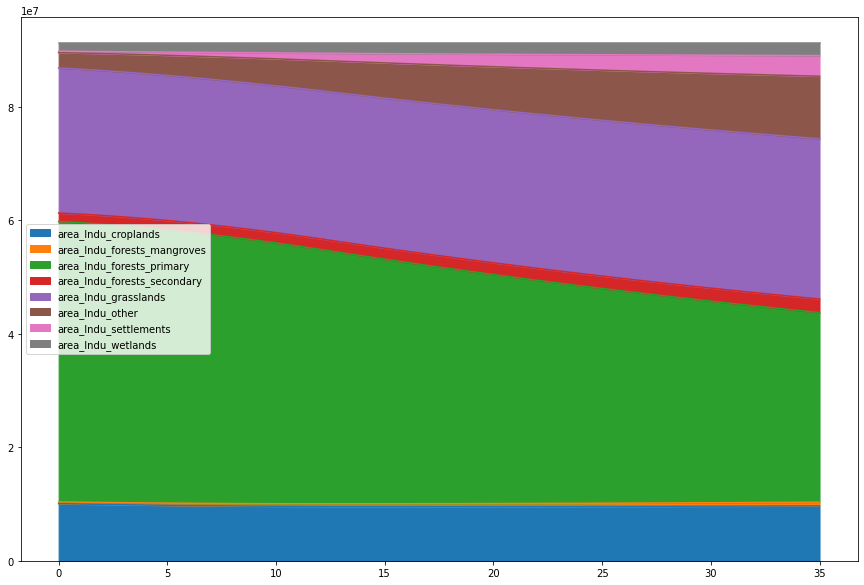